<a href="https://colab.research.google.com/github/dkomlen/finance-ml/blob/main/loan_default_probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

#Libraries for Saving the Model
from pickle import dump
from pickle import load

#### 2.2 Loading the data

In [2]:
loans = pd.read_csv('https://github.com/tatsath/fin-ml/raw/master/Chapter%206%20-%20Sup.%20Learning%20-%20Classification%20models/CaseStudy2%20-%20Loan%20Default%20Probability/LoansData_sample.csv.gz', compression='gzip', encoding='utf-8')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
dataset = loans

In [4]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
type(dataset)

pandas.core.frame.DataFrame

In [6]:
dataset.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,0,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,2,37842129,NaN,21425.0,21425.0,21425.0,60 months,15.59,516.36,D,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,3,37612354,NaN,12800.0,12800.0,12800.0,60 months,17.14,319.08,D,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,4,37662224,NaN,7650.0,7650.0,7650.0,36 months,13.66,260.20,C,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
dataset.columns

Index(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)

In [8]:
dataset.describe()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,100000.000000,1.000000e+05,0.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,...,185.0,185.000000,185.0,185.000000,152.000000,185.000000,185.000000,1290.000000,1290.000000,1290.000000
mean,49999.500000,3.029995e+07,NaN,14886.930000,14886.930000,14883.910500,13.278073,437.331824,7.468924e+04,18.769787,...,3.0,110.335568,3.0,14.037838,323.495132,8046.616541,186.563135,4768.376357,47.720519,8.265116
std,28867.657797,4.763500e+06,NaN,8504.432514,8504.432514,8502.519174,4.390210,244.317648,5.809527e+04,8.539769,...,0.0,89.266601,0.0,9.657374,267.627244,5585.653253,168.552986,3703.963945,7.046587,8.263566
min,0.000000,5.716700e+04,NaN,1000.000000,1000.000000,1000.000000,6.000000,30.420000,4.000000e+03,0.000000,...,3.0,1.470000,3.0,0.000000,4.410000,174.150000,0.040000,233.160000,0.550000,0.000000
25%,24999.750000,2.737015e+07,NaN,8000.000000,8000.000000,8000.000000,10.150000,261.640000,4.500000e+04,12.320000,...,3.0,23.760000,3.0,7.000000,63.885000,2465.360000,27.610000,1951.125000,45.000000,0.000000
50%,49999.500000,3.052556e+07,NaN,13050.000000,13050.000000,13050.000000,12.990000,380.180000,6.400000e+04,18.210000,...,3.0,96.580000,3.0,15.000000,281.580000,8049.850000,172.460000,3881.120000,45.040000,6.000000
75%,74999.250000,3.438201e+07,NaN,20000.000000,20000.000000,20000.000000,15.610000,573.320000,9.000000e+04,24.760000,...,3.0,164.750000,3.0,22.000000,481.492500,11968.940000,285.890000,6503.000000,50.000000,14.000000
max,99999.000000,3.809811e+07,NaN,35000.000000,35000.000000,35000.000000,26.060000,1408.130000,7.500000e+06,39.990000,...,3.0,382.340000,3.0,32.000000,1147.020000,21750.750000,757.420000,26751.740000,100.000000,36.000000


### 3. Data Preparation and Feature Selection

##### 3.1 Preparing the predicted variable

In [9]:
dataset['loan_status'].value_counts(dropna=False)

Fully Paid            69982
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: loan_status, dtype: int64

In [10]:
dataset = dataset.loc[dataset['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [11]:
dataset['loan_status'].value_counts(dropna=False)

Fully Paid     69982
Charged Off    16156
Name: loan_status, dtype: int64

In [12]:
dataset['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.812441
Charged Off    0.187559
Name: loan_status, dtype: float64

In [13]:
dataset['charged_off'] = (dataset['loan_status'] == 'Charged Off').apply(np.uint8)
dataset.drop('loan_status', axis=1, inplace=True)

In [14]:
dataset['charged_off'].value_counts(normalize=True, dropna=False)

0    0.812441
1    0.187559
Name: charged_off, dtype: float64

### 3.2.1 Features elimination by significant mising values

In [15]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

In [16]:
missing_fractions.head(10)

total_cu_tl                            1.0
annual_inc_joint                       1.0
sec_app_mths_since_last_major_derog    1.0
sec_app_collections_12_mths_ex_med     1.0
sec_app_chargeoff_within_12_mths       1.0
open_rv_12m                            1.0
sec_app_num_rev_accts                  1.0
sec_app_open_act_il                    1.0
sec_app_revol_util                     1.0
sec_app_open_acc                       1.0
dtype: float64

In [17]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

In [18]:
drop_list

['all_util',
 'annual_inc_joint',
 'debt_settlement_flag_date',
 'deferral_term',
 'desc',
 'dti_joint',
 'hardship_amount',
 'hardship_dpd',
 'hardship_end_date',
 'hardship_last_payment_amount',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_reason',
 'hardship_start_date',
 'hardship_status',
 'hardship_type',
 'il_util',
 'inq_fi',
 'inq_last_12m',
 'max_bal_bc',
 'member_id',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_rcnt_il',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'next_pymnt_d',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'open_rv_12m',
 'open_rv_24m',
 'orig_projected_additional_accrued_interest',
 'payment_plan_start_date',
 'revol_bal_joint',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_earliest_cr_line',
 'sec_app_fico_range_high',
 'sec_app_fico_range_low',
 'sec_app_inq_last_6mths',
 'se

In [19]:
len(drop_list)

58

In [20]:
dataset.drop(labels=drop_list, axis=1, inplace=True)

In [21]:
dataset.shape

(86138, 93)

### 3.2.2. Features elimination based on the intuitiveness

In [ ]:
sorted(dataset.columns)

In [25]:
keep_list = ['charged_off','funded_amnt','addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code','last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy","avg_cur_bal","acc_open_past_24mths" ]

len(keep_list)

40

In [26]:
drop_list = [col for col in dataset.columns if col not in keep_list]

dataset.drop(labels=drop_list, axis=1, inplace=True)

In [27]:
dataset.shape

(86138, 39)

### 3.2.2. Features elimination based on correlation

In [33]:
correlation = dataset.corr()
correlation_chargeOff = abs(correlation['charged_off'])

In [34]:
correlation_chargeOff.sort_values(ascending=False)

charged_off              1.000000
last_pymnt_amnt          0.319081
int_rate                 0.282825
dti                      0.123108
fico_range_low           0.121892
fico_range_high          0.121891
acc_open_past_24mths     0.105989
bc_open_to_buy           0.080077
bc_util                  0.077744
avg_cur_bal              0.071977
num_actv_rev_tl          0.071185
revol_util               0.066188
loan_amnt                0.060818
funded_amnt              0.060818
mort_acc                 0.057858
annual_inc               0.050349
mo_sin_old_rev_tl_op     0.049426
mo_sin_rcnt_rev_tl_op    0.048839
open_acc                 0.039430
installment              0.032847
revol_bal                0.021714
pub_rec                  0.016023
pub_rec_bankruptcies     0.015815
total_acc                0.005804
id                       0.002221
Name: charged_off, dtype: float64

In [35]:
drop_list_corr = sorted(list(correlation_chargeOff[correlation_chargeOff < 0.03].index))

In [36]:
drop_list_corr

['id', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'total_acc']

In [37]:
dataset.drop(labels=drop_list_corr, axis=1, inplace=True)
dataset.shape

(86138, 34)

### 4. Feature Engineering and Exploratory Analysis

In [38]:
dataset.describe()

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,open_acc,revol_util,last_pymnt_amnt,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off
count,86138.000000,86138.000000,86138.000000,86138.000000,8.613800e+04,86138.000000,86138.000000,86138.000000,86138.000000,86094.000000,86138.000000,86138.000000,86138.000000,85142.000000,85089.000000,86138.000000,86138.000000,86138.000000,86138.000000,86138.000000
mean,14106.526446,14106.526446,13.002360,430.737187,7.384311e+04,18.532747,692.462966,696.463024,11.746453,54.582777,4757.453184,4.594732,13066.638371,8942.506507,63.808959,183.524333,12.796896,1.748880,5.762358,0.187559
std,8391.139221,8391.139221,4.397419,251.653139,5.929352e+04,8.538247,29.731549,29.731848,5.433122,23.515901,6466.767327,3.070996,16232.739293,14100.186250,27.051347,93.266430,16.224586,2.091488,3.224598,0.390362
min,1000.000000,1000.000000,6.000000,30.420000,4.000000e+03,0.000000,660.000000,664.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,7800.000000,7800.000000,9.490000,248.480000,4.500000e+04,12.070000,670.000000,674.000000,8.000000,37.200000,358.522500,2.000000,3010.000000,1087.000000,44.100000,118.000000,3.000000,0.000000,3.000000,0.000000
50%,12000.000000,12000.000000,12.990000,370.480000,6.247372e+04,17.950000,685.000000,689.000000,11.000000,54.900000,1241.230000,4.000000,6994.500000,3823.000000,67.700000,167.000000,8.000000,1.000000,5.000000,0.000000
75%,20000.000000,20000.000000,15.610000,568.005000,9.000000e+04,24.500000,705.000000,709.000000,14.000000,72.500000,7303.205000,6.000000,17905.000000,10588.000000,87.500000,232.000000,15.000000,3.000000,7.000000,0.000000
max,35000.000000,35000.000000,26.060000,1408.130000,7.500000e+06,39.990000,845.000000,850.000000,84.000000,180.300000,36234.440000,53.000000,447433.000000,249625.000000,255.200000,718.000000,372.000000,34.000000,38.000000,1.000000


### 4.1 Feature Analysis and Exploration

#### 4.1.1. Analysing the categorical features

In [42]:
dataset[['emp_title','title','zip_code']].describe()

,emp_title,title,zip_code
count,81416,86138,86138
unique,32987,20,846
top,Teacher,Debt consolidation,750xx
freq,1576,52990,954


In [45]:
dataset.drop(['emp_title','title','zip_code'], axis=1, inplace=True)

In [46]:
dataset.shape

(86138, 31)

#### Feature Term

In [56]:
dataset['term'] = dataset['term'].apply(lambda s: np.int8(s.split()[0]))

AttributeError: ignored

In [57]:
dataset.groupby('term')['charged_off'].value_counts(normalize=True).loc[:,1]

term
36    0.141526
60    0.354356
Name: charged_off, dtype: float64

#### Feature Employment Length

In [58]:
dataset['emp_length'].value_counts()

10+ years    28177
2 years       7699
< 1 year      7060
3 years       6784
1 year        5482
4 years       5255
7 years       4582
5 years       4519
8 years       4319
6 years       4103
9 years       3441
Name: emp_length, dtype: int64

In [59]:
dataset['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
dataset['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [65]:
dataset['emp_length'].value_counts(dropna = False)

10 years    28177
2 years      7699
0 years      7060
3 years      6784
1 year       5482
4 years      5255
NaN          4717
7 years      4582
5 years      4519
8 years      4319
6 years      4103
9 years      3441
Name: emp_length, dtype: int64

In [68]:
dataset['emp_length'] = dataset['emp_length'].apply(lambda s: s if pd.isnull(s) else np.int8(s.split()[0]))

In [69]:
dataset['emp_length'].value_counts(dropna = False)

10.0    28177
2.0      7699
0.0      7060
3.0      6784
1.0      5482
4.0      5255
NaN      4717
7.0      4582
5.0      4519
8.0      4319
6.0      4103
9.0      3441
Name: emp_length, dtype: int64

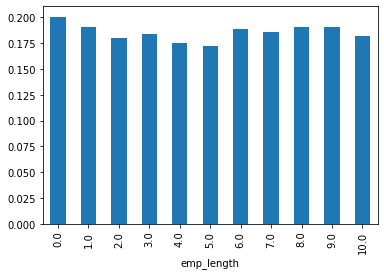

In [74]:
charge_off_rates = dataset.groupby('emp_length')['charged_off'].value_counts(normalize=True).loc[:,1]
charge_off_rates.plot(kind='bar');

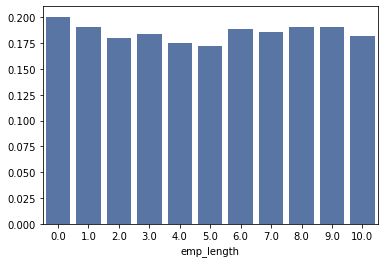

In [77]:
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)

In [86]:
dataset.drop(['emp_length'], axis=1, inplace=True)

### Feature : Subgrade

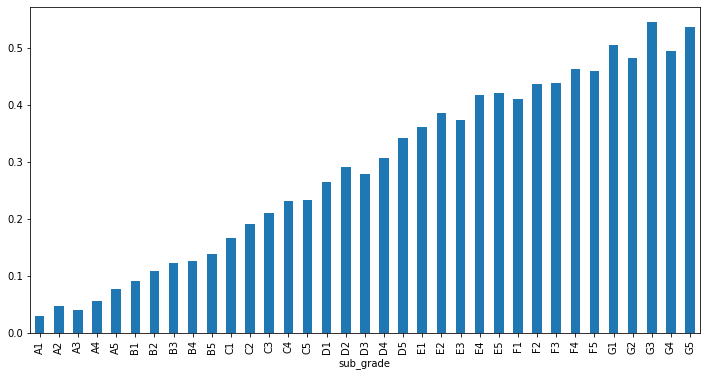

In [90]:
charge_off_rates = dataset.groupby('sub_grade')['charged_off'].value_counts(normalize=True).loc[:,1]
charge_off_rates.plot(kind='bar', figsize=(12,6));

In [96]:
dataset['earliest_cr_line'] = dataset['earliest_cr_line'].apply(lambda s: int(s[-4:]))

#### 4.1.2. Analysing the continuous features

##### Feature : Annual Income

In [98]:
dataset[['annual_inc']].describe()

,annual_inc
count,8.613800e+04
mean,7.384311e+04
std,5.929352e+04
min,4.000000e+03
25%,4.500000e+04
50%,6.247372e+04
75%,9.000000e+04
max,7.500000e+06


In [100]:
dataset['log_annual_inc'] = dataset['annual_inc'].apply(lambda x: np.log10(x+1))
dataset.drop('annual_inc', axis=1, inplace=True)

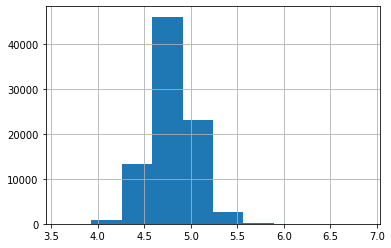

In [103]:
dataset['log_annual_inc'].hist();

#### FIFO Scores